# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.


## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Librerías

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

## Preparación

In [ ]:
# Cargar DataFrame
data = pd.read_csv("/data/taxi.csv")

In [3]:
# Explorar Dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
#Cambiar columna datetime a Dtype Datetime 
data = pd.read_csv("/datasets/taxi.csv",index_col=[0], parse_dates = [0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data.head(20)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [7]:
#Verificar si están ordenadas cronologicamente
print(data.index.is_monotonic)

True


In [8]:
#Revisar si hay fechas duplicadas en el index
data.index.duplicated().any()

False

In [9]:
#Remuestrear por hora
data = data.resample("1H").sum()


## Análisis

In [10]:
#Verificar si hay valores negativos
neg_ratio = (data["num_orders"]<0).mean()
print(neg_ratio)

0.0


In [11]:
#Explaración de datos
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


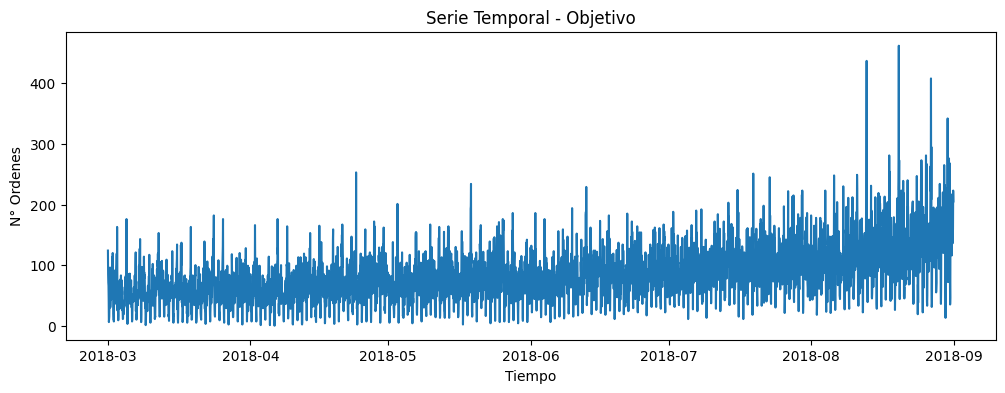

In [12]:
plt.figure(figsize=(12,4))
plt.plot(data.index,data["num_orders"])
plt.title("Serie Temporal - Objetivo")
plt.xlabel("Tiempo")
plt.ylabel("N° Ordenes")
plt.show()

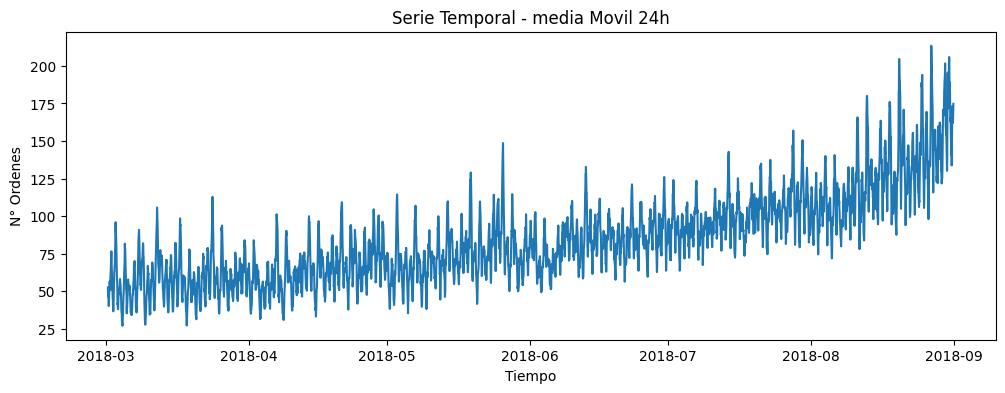

In [13]:
#Media Móvil 24 h
data_rolling_mean_24 = data.rolling(10).mean()
plt.figure(figsize=(12,4))
plt.plot(data_rolling_mean_24.index,data_rolling_mean_24["num_orders"])
plt.title("Serie Temporal - media Movil 24h")
plt.xlabel("Tiempo")
plt.ylabel("N° Ordenes")
plt.show()


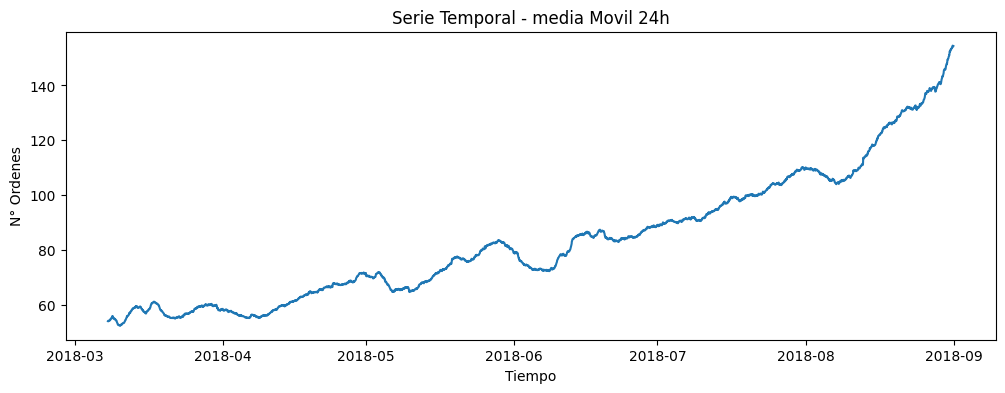

In [14]:
#Media Móvil 168 h (1 semana)
data_rolling_mean_168 = data.rolling(168).mean()
plt.figure(figsize=(12,4))
plt.plot(data_rolling_mean_168.index,data_rolling_mean_168["num_orders"])
plt.title("Serie Temporal - media Movil 24h")
plt.xlabel("Tiempo")
plt.ylabel("N° Ordenes")
plt.show()


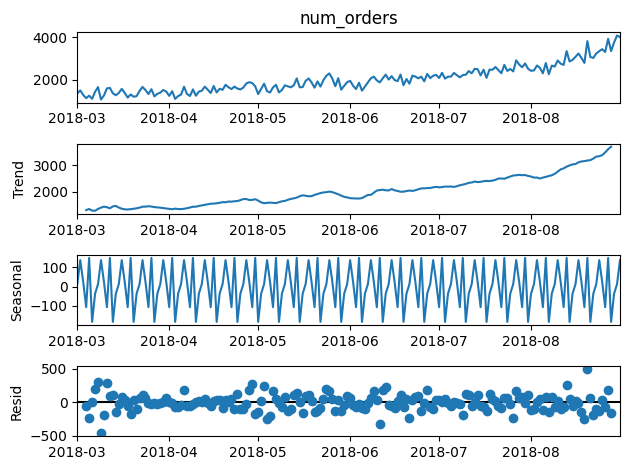

<Figure size 2400x800 with 0 Axes>

In [15]:
day = data['num_orders'].resample('24H').sum()


decomposed = seasonal_decompose(day)
decomposed.plot()
plt.figure(figsize=(24,8))
plt.show()



<AxesSubplot:xlabel='datetime'>

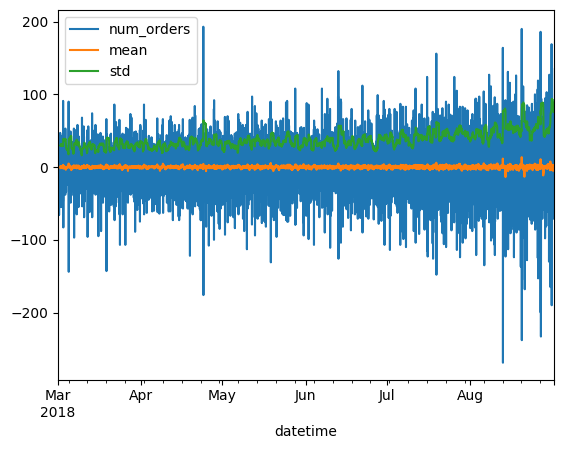

In [16]:
data -= data.shift()

data['mean'] = data['num_orders'].rolling(24).mean()
data['std'] = data['num_orders'].rolling(24).std()
data.plot()

<span style="color:green">


En la gráfica de descomposición de la serie temporal se observan las tres componentes principales: tendencia, estacionalidad y residuales.
La tendencia muestra un crecimiento sostenido en el número de pedidos a lo largo del tiempo, especialmente notorio a partir del mes de julio de 2018, lo que indica un incremento progresivo en la demanda del servicio.

La componente estacional refleja un patrón periódico que se repite de manera constante, caracterizado por oscilaciones regulares en intervalos similares. Este comportamiento sugiere que existen momentos del día o de la semana en los que se concentran más pedidos, posiblemente asociados a los horarios de mayor actividad o demanda.

La segunda gráfica, que representa la serie original junto con la media y la desviación estándar móviles, confirma la variabilidad creciente a lo largo del tiempo. Se aprecia un incremento en la dispersión de los datos, lo que sugiere una mayor inestabilidad o volatilidad en los pedidos conforme avanza el periodo analizado, es decir los pedidos fluctúan más, hay horas con muchos pedidos y otras con muy pocos.

En conjunto, el análisis evidencia una serie temporal NO ESTACIONARIA, con una tendencia creciente y una marcada estacionalidad, lo que deberá ser considerado en etapas posteriores del modelado.

## Formación

In [17]:
#Conjunto de entrenamiento y prueba y verificación del orden cronológico 
train, test = train_test_split (data, shuffle=False, test_size=0.1)
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [18]:
#Prueba de cordura - Media

print("Pedidos de Taxi por hora", test["num_orders"].median())
pred_median = np.ones(len(test)) * train["num_orders"].median()
print("RECM:", mean_squared_error(test["num_orders"], pred_median, squared=False))

Pedidos de Taxi por hora 1.5
RECM: 58.861675414306596


In [19]:
#Prueba de cordura - Shift()
print("Pedidos de Taxi por hora", test["num_orders"].median())

# Predicción usando valor anterior
pred_previous = test["num_orders"].shift()
pred_previous.iloc[0] = train["num_orders"].iloc[-1]

# RECM (RMSE)
rmse = mean_squared_error(test["num_orders"], pred_previous, squared=False)
print("RECM:", rmse)

Pedidos de Taxi por hora 1.5
RECM: 92.98193518900976


<span style="color:green">

En ambas pruebas se observa que la mediana de pedidos por hora en el conjunto de test es baja (1.5 pedidos). Sin embargo, al comparar los métodos de predicción, se aprecia que el uso de la mediana como estimación produce una raíz del error cuadrático medio (RECM) menor (58.86), mientras que la predicción basada en el valor de la hora anterior genera un RECM mayor (92.98). Esto indica que el modelo “valor anterior” tiene una mayor desviación respecto a los datos reales, lo que refleja que la serie de pedidos presenta alta variabilidad y picos significativos.

In [20]:
#Crear caracteristicas
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data["num_orders"].shift(lag)

    data['rolling_mean'] = data["num_orders"].shift().rolling(rolling_mean_size).mean()

make_features(data, 25, 4)

print(data.head())

                     num_orders  mean  std  year  month  day  dayofweek  \
datetime                                                                  
2018-03-01 00:00:00         NaN   NaN  NaN  2018      3    1          3   
2018-03-01 01:00:00       -39.0   NaN  NaN  2018      3    1          3   
2018-03-01 02:00:00       -14.0   NaN  NaN  2018      3    1          3   
2018-03-01 03:00:00        -5.0   NaN  NaN  2018      3    1          3   
2018-03-01 04:00:00       -23.0   NaN  NaN  2018      3    1          3   

                     lag_1  lag_2  lag_3  ...  lag_17  lag_18  lag_19  lag_20  \
datetime                                  ...                                   
2018-03-01 00:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00  -39.0    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00  -14.0  -39.0    NaN  ...     NaN     NaN     NaN

In [21]:
data = data.drop('mean', axis=1)


In [22]:
data = data.drop('std', axis=1)

print(data)

                     num_orders  year  month  day  dayofweek  lag_1  lag_2  \
datetime                                                                     
2018-03-01 00:00:00         NaN  2018      3    1          3    NaN    NaN   
2018-03-01 01:00:00       -39.0  2018      3    1          3    NaN    NaN   
2018-03-01 02:00:00       -14.0  2018      3    1          3  -39.0    NaN   
2018-03-01 03:00:00        -5.0  2018      3    1          3  -14.0  -39.0   
2018-03-01 04:00:00       -23.0  2018      3    1          3   -5.0  -14.0   
...                         ...   ...    ...  ...        ...    ...    ...   
2018-08-31 19:00:00       -71.0  2018      8   31          4  -10.0   20.0   
2018-08-31 20:00:00        18.0  2018      8   31          4  -71.0  -10.0   
2018-08-31 21:00:00         5.0  2018      8   31          4   18.0  -71.0   
2018-08-31 22:00:00        64.0  2018      8   31          4    5.0   18.0   
2018-08-31 23:00:00       -18.0  2018      8   31          4   6

In [23]:
#Realizar cnjunto de test y prueba final
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()


features_train = train.drop(["num_orders"], axis=1)
target_train = train["num_orders"]
features_test = test.drop(["num_orders"], axis=1)
target_test = test["num_orders"]


## Prueba

In [24]:
%%time
#Modelo 1: Regresión lineal
model = LinearRegression()
model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

# RECM / RMSE
print("RECM para el conjunto de entrenamiento:", mean_squared_error(target_train, pred_train, squared=False))
print("RECM para el conjunto de prueba:", mean_squared_error(target_test, pred_test, squared=False))

RECM para el conjunto de entrenamiento: 25.816703949931753
RECM para el conjunto de prueba: 45.212667506883506
CPU times: user 72.6 ms, sys: 206 ms, total: 278 ms
Wall time: 76.3 ms


In [25]:
%%time
#Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=300,max_depth=15,min_samples_leaf=5,random_state=1505)

model_rf.fit(features_train, target_train)

pred_train_rf = model_rf.predict(features_train)
pred_test_rf  = model_rf.predict(features_test)

rmse_train_rf = mean_squared_error(target_train, pred_train_rf, squared=False)
rmse_test_rf  = mean_squared_error(target_test, pred_test_rf, squared=False)

print("RandomForest - RECM (train):", rmse_train_rf)
print("RandomForest - RECM (test) :", rmse_test_rf)


RandomForest - RECM (train): 16.386489772751435
RandomForest - RECM (test) : 49.65827799228454
CPU times: user 10.6 s, sys: 0 ns, total: 10.6 s
Wall time: 10.6 s


In [26]:
%%time
#LightBGM

lgbm = lgb.LGBMRegressor(objective='regression',n_estimators=200,learning_rate=0.05,random_state=1505)

lgbm.fit(features_train, target_train)

# Predicciones
pred_train_lgb = lgbm.predict(features_train)
pred_test_lgb  = lgbm.predict(features_test)

# Cálculo del RECM (RMSE)
rmse_train_lgb = mean_squared_error(target_train, pred_train_lgb, squared=False)
rmse_test_lgb  = mean_squared_error(target_test, pred_test_lgb, squared=False)

# Resultados
print("LightGBM - RECM (train):", rmse_train_lgb)
print("LightGBM - RECM (test) :", rmse_test_lgb)

LightGBM - RECM (train): 13.936400630184536
LightGBM - RECM (test) : 45.91579767639457
CPU times: user 9min 59s, sys: 746 ms, total: 10min
Wall time: 5min


<span style="color:green">

El proyecto tuvo como objetivo predecir la cantidad de pedidos de taxi por hora para la compañía Sweet Lift Taxi. Para ello, se analizaron los datos históricos, se remuestrearon en intervalos de una hora y se generaron características temporales como año, mes, día, día de la semana, retardos y medias móviles.

Se entrenaron distintos modelos de regresión y se evaluó su desempeño mediante la métrica RECM (raíz del error cuadrático medio) en los conjuntos de entrenamiento y prueba. Los resultados obtenidos fueron los siguientes:

Regresión lineal: RECM (train) = 25.82, RECM (test) = 45.21

Random Forest: RECM (train) = 16.39, RECM (test) = 49.66

LightGBM: RECM (train) = 13.94, RECM (test) = 45.92

Los tres modelos presentaron un buen desempeño, aunque el modelo de regresión lineal mostró el mejor equilibrio entre ajuste y generalización, con el menor error en el conjunto de prueba y cumpliendo con la métrica requerida (RECM < 48).

Se observó que la serie temporal no es completamente estacionaria, ya que su media y varianza cambian a lo largo del tiempo, probablemente debido a la influencia de factores como el día de la semana y la hora del día. No obstante, la incorporación de retardos (lags) y medias móviles permitió mejorar la capacidad de los modelos para capturar dichas variaciones.

En conclusión, el modelo de regresión lineal se considera el más adecuado para predecir la demanda horaria de taxis, al ofrecer un desempeño competitivo con menor complejidad computacional y cumplir con el objetivo establecido por la compañía.